In [2]:
import dexpy.optimal
from dexpy.model import ModelOrder
import numpy as np

import matplotlib.pyplot as plt

from dexpy.model import make_model, ModelOrder
from patsy import dmatrix
import numpy as np

import os
import sys
sys.path.append("../../Benchmark/functions/")
import pandas as pd

import scenarios as sc

In [3]:
def closest_value(input_list, input_value):
    arr = np.asarray(input_list)
    i = (np.abs(arr - input_value)).argmin()
    return arr[i]

promoter_list=[0.25, 0.5, 1, 1.5,2,4]
def clip_on_simulated_values(recommendations1,promoter_list):
    for i,k in enumerate(recommendations1):
        # print(i)
        x=recommendations1[k]
        for j,l in enumerate(x):
            close=closest_value(promoter_list,l)
            # print(close)
            recommendations1.iloc[j,i]=close
    return recommendations1

#helper functions
def find_set_designs(comb_space,tcart,enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    temp=0
    tset = pd.DataFrame()
    for design in tcart:
        sub=comb_space
        sub=sub.loc[sub['vmax_forward_Enzyme_A']==design[0]]
        sub=sub.loc[sub['vmax_forward_Enzyme_B']==design[1]]
        sub=sub.loc[sub['vmax_forward_Enzyme_C']==design[2]]
        sub=sub.loc[sub['vmax_forward_Enzyme_D']==design[3]]
        sub=sub.loc[sub['vmax_forward_Enzyme_E']==design[4]]
        sub=sub.loc[sub['vmax_forward_Enzyme_F']==design[5]]
        sub=sub.loc[sub['vmax_forward_Enzyme_G']==design[6]]
        tset=pd.concat([tset,sub])
    return tset,tcart

def D_efficiency(D1,D2):
    return (D1/D2)**(1/36)


def train_model(train_x,train_y):
    #random forest 
    regr_gbr = BayesSearchCV(
    GradientBoostingRegressor(),
    {
        "min_samples_split":(2,3,4,5,6,7,8),
        "min_samples_leaf":(2,3,4,5,6,7,8),
        "max_depth": (1,2,3,4,5,7,8),
        "learning_rate":(0.00001,0.0001,0.001,0.01,0.1,0.2,0.3),
    },
    n_iter=20,
    cv=5)
    regr_gbr.fit(train_x,train_y)
    return regr_gbr


In [110]:
def Doptimal_Design(N_samples):
    column_names=['vmax_forward_enzyme_A',"vmax_forward_enzyme_B","vmax_forward_enzyme_C",
                "vmax_forward_enzyme_D","vmax_forward_enzyme_E","vmax_forward_enzyme_F","vmax_forward_enzyme_G"]
    promoter_list=[0.25, 0.5, 1, 1.5,2,4]
    lows=np.array(0.25)+np.zeros(7)
    highs=np.array(4)+np.zeros(7)


    actual_lows=dict(zip(column_names,lows))
    actual_highs=dict(zip(column_names,highs))

    reaction_design=dexpy.optimal.build_optimal(7,run_count=N_samples, order=ModelOrder.quadratic)
    reaction_design.columns=column_names
    reaction_design=dexpy.design.coded_to_actual(reaction_design, actual_lows, actual_highs)

    #clip on simulated values
    reaction_design=clip_on_simulated_values(reaction_design,promoter_list)

    quad_model = make_model(reaction_design.columns, ModelOrder.quadratic)
    X = dmatrix(quad_model, reaction_design)
    XtX = np.dot(np.transpose(X), X)
    d = np.linalg.det(XtX)
    return reaction_design,d


In [104]:
def Random_Design(N_samples):
    column_names=['vmax_forward_enzyme_A',"vmax_forward_enzyme_B","vmax_forward_enzyme_C",
                "vmax_forward_enzyme_D","vmax_forward_enzyme_E","vmax_forward_enzyme_F","vmax_forward_enzyme_G"]
    x,y=sc.scenario1(promoter_list,N_samples,column_names)
    reaction_design=pd.DataFrame(y,columns=column_names)
    quad_model = make_model(reaction_design.columns, ModelOrder.quadratic)
    X = dmatrix(quad_model, reaction_design)
    XtX = np.dot(np.transpose(X), X)
    d = np.linalg.det(XtX)
    return reaction_design,d



In [48]:
from scipy.stats import qmc
def LatinHypercubeDesign(N_samples):
    column_names=['vmax_forward_enzyme_A',"vmax_forward_enzyme_B","vmax_forward_enzyme_C",
            "vmax_forward_enzyme_D","vmax_forward_enzyme_E","vmax_forward_enzyme_F","vmax_forward_enzyme_G"]
    promoter_list=[0.25, 0.5, 1, 1.5,2,4]
    lows=np.array(0.25)+np.zeros(7)
    highs=np.array(4)+np.zeros(7)
    
    
    x=qmc.LatinHypercube(d=7)
    x=x.random(n=N_samples)
    x=pd.DataFrame(qmc.scale(x,lows,highs))
    x.columns=column_names
    
    reaction_design=clip_on_simulated_values(x,promoter_list)

    quad_model = make_model(reaction_design.columns, ModelOrder.quadratic)
    X = dmatrix(quad_model, reaction_design)
    XtX = np.dot(np.transpose(X), X)
    d = np.linalg.det(XtX)
    
    return reaction_design,d





In [124]:
N_samples=[50,200]

eff_random_dict={}
eff_lhs_dict={}
for i in N_samples:
    efficiency_random_list=[]
    efficiency_LHS_list=[]
    for j in range(20):
        print(j)
        Random_Designs,d_random=Random_Design(i)
        Doptimal_Designs,d_doptimal=Doptimal_Design(i)
        LHS_designs,d_LHS=LatinHypercubeDesign(i)

        efficiency_random=D_efficiency(d_random,d_doptimal)
        print(efficiency_random)
        efficiency_LHS=D_efficiency(d_LHS,d_doptimal)
        print(efficiency_LHS)
        efficiency_LHS_list.append(efficiency_LHS)
        efficiency_random_list.append(efficiency_random)
    eff_random_dict[str(i)]=efficiency_random_list
    eff_lhs_dict[str(i)]=efficiency_LHS_list

0
0.24807744397500103
0.25728774813328975
1
0.2562443375245502
0.26415348921966714
2
0.17409382171412507
0.22744212062722188
3
0.1651395933078524
0.25908403023049653
4
0.2250790121711996
0.24568186152503288
5
0.20158497910921536
0.23126319587711477
6
0.2332364730918684
0.25071039767855385
7
0.19524127218869397
0.2469796930979849
8
0.24188782264617784
0.2536560668183012
9
0.21934459349114035
0.24941596911270633
10
0.1866016902283364
0.25777115989756977
11
0.26852379417120387
0.24728939478556133
12
0.2568132877996033
0.2584201690959122
13
0.2592381255519093
0.22949394462748585
14
0.2312268291374786
0.25478861360405375
15
0.21482950496563355
0.255965550943758
16
0.18371673535333932
0.23563767891634813
17
0.2188916566098507
0.27394792945151974
18
0.1747654200786318
0.231120031532328
19
0.22928072771347416
0.2677344061771928
0
0.37916633876509587
0.36487349643696015
1
0.4004442471029862
0.3612907515098973
2
0.36052755800850456
0.3649756753979164
3
0.3341200155393284
0.36869611199622687
4
0.

In [134]:
RS=pd.DataFrame(eff_random_dict)
LHS=pd.DataFrame(eff_lhs_dict)
RS.to_csv("../../Benchmark/results/statistical_analysis/RandomSample_Defficiency.csv")
LHS.to_csv("../../Benchmark/results/statistical_analysis/LHS_Defficiency.csv")

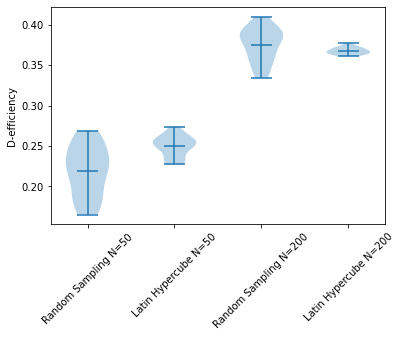

In [55]:
RS=pd.read_csv("../../Benchmark/results/statistical_analysis/RandomSample_Defficiency.csv",index_col=0)
LHS=pd.read_csv("../../Benchmark/results/statistical_analysis/LHS_Defficiency.csv",index_col=0)



RS.columns=["Random Sampling N=50","Random Sampling N=200"]
RS['Latin Hypercube N=50']=LHS['50']
RS['Latin Hypercube N=200']=LHS['200']
cols=["Random Sampling N=50",'Latin Hypercube N=50',"Random Sampling N=200",'Latin Hypercube N=200']
RS=RS[cols]


pos=[1,2,3,4]
fig,ax=plt.subplots()
plt.violinplot(RS,showmeans=True)
ax.set_xticks(pos)
ax.set_xticklabels(cols,rotation=45)
plt.ylabel("D-efficiency")
plt.savefig("../../../Results/Benchmark paper/Defficiency_LHS_RS_revision.svg",bbox_inches="tight")



## Compare performance between methods

In [111]:
from scipy.stats import linregress
from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV

column_names=['vmax_forward_enzyme_A',"vmax_forward_enzyme_B","vmax_forward_enzyme_C",
            "vmax_forward_enzyme_D","vmax_forward_enzyme_E","vmax_forward_enzyme_F","vmax_forward_enzyme_G"]
comb_space=pd.read_csv("../../Benchmark/data/combinatorial_space/combinatorial_space_pathway_A.csv")


pearson_dict={}
top100_dict={}
N_samples=[50,200]

for j in N_samples:
    top100_list=[]
    pearson_list=[]
    for i in range(20):
        designs,d=Doptimal_Design(j)
        train,tcart=find_set_designs(comb_space,tuple(np.array(designs)),column_names)
        train_x=train.iloc[:,:-1]
        train_y=train.iloc[:,-1]

        test_x=comb_space.iloc[:,:-1]
        test_y=comb_space.iloc[:,-1]

        GBR=train_model(train_x,train_y)
        prediction=GBR.predict(test_x)

        #evaluate
        slope, intercept, r_value, p_value, std_err = linregress(test_y,prediction)
        score=r_value**2
        top100=np.argsort(test_y)[::-1][0:100]
        top100_pred=np.argsort(prediction)[::-1][0:100]
        top100=len(np.intersect1d(top100,top100_pred))
        top100_designs=top100_pred
        pearson_list.append(score)
        top100_list.append(top100)
        print(score,top100)
    pearson_dict[str(j)]=pearson_list
    top100_dict[str(j)]=top100_list

0.30898015611657176 0
0.4231392958224659 2
0.4451050074839264 0


/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.5878958381701973 17
0.5505832422540043 2
0.5546794019454111 2


/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.6489481987694037 0
0.5843695452491419 13
0.6126477046167894 6
0.43210875986700453 10
0.44013560777618516 0
0.35033982763508476 0
0.6636413145454169 0
0.41412123557881303 0
0.4881593554477628 0
0.45709177199078965 5
0.597746220150905 3
0.53508019412722 9
0.48686052616954945 7
0.6062018664951011 0
0.4625533030716256 20
0.4578573700600746 22
0.4730951836944489 18
0.4528896373938619 18
0.47970119706444025 23
0.4690783752653111 31
0.4607036200451245 12
0.4612261952512583 18
0.4925750155771263 14
0.45761732971503016 25
0.48079306408035843 31
0.464561071216117 14
0.47886177371552935 23
0.47237845348086066 15
0.47329980781428627 4
0.4607196637397664 15
0.4664445906063846 12
0.4661492484650884 20
0.47567080907007875 8
0.4530410102152716 9


In [112]:
top100_dict=pd.DataFrame(top100_dict)
pearson_dict=pd.DataFrame(pearson_dict)
top100_dict.to_csv("../../Benchmark/results/statistical_analysis/top100_Doptimal.csv")
pearson_dict.to_csv("../../Benchmark/results/statistical_analysis/pearson_Doptimal.csv")


In [60]:
R_pearson=pd.read_csv("../../Benchmark/results/statistical_analysis/pearson_RS.csv",index_col=0)
R_LHS=pd.read_csv("../../Benchmark/results/statistical_analysis/pearson_LHS.csv",index_col=0)
R_Doptimal=pd.read_csv("../../Benchmark/results/statistical_analysis/pearson_Doptimal.csv",index_col=0)

R_Doptimal.columns=["Doptimal_N=50","Doptimal_N=200"]
R_Doptimal['LHS_N=50']=R_LHS['50']
R_Doptimal['LHS_N=200']=R_LHS['200']
R_Doptimal['RS_N=200']=R_pearson['200']
R_Doptimal['RS_N=50']=R_pearson['50']
cols=["Doptimal_N=50","LHS_N=50","RS_N=50","Doptimal_N=200","LHS_N=200","RS_N=200"]
R_Doptimal=R_Doptimal[cols]

## DO the analysis

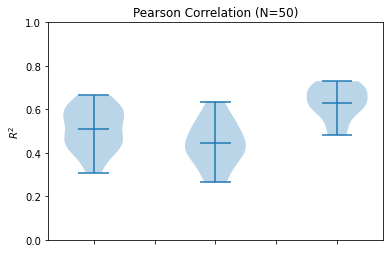

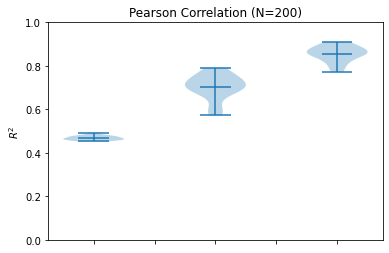

In [63]:
pos=[1,2,3]
fig,ax=plt.subplots()
plt.violinplot(R_Doptimal.iloc[:,:3],showmeans=True)
# ax.set_xticks(pos)
plt.title("Pearson Correlation (N=50)")
cols_50=["D optimal", "Latin Hypercube","Random Sampling"]
ax.set_xticklabels([],rotation=45)
plt.ylabel("$R^2$")
plt.ylim((0,1))
plt.savefig("../../../Results/Benchmark paper/R2_D_LHS_RS_50.svg",bbox_inches="tight")
plt.show()

pos=[1,2,3]
fig,ax=plt.subplots()
plt.violinplot(R_Doptimal.iloc[:,3:],showmeans=True)
# ax.set_xticks(pos)
plt.title("Pearson Correlation (N=200)")
cols_50=["D optimal", "Latin Hypercube","Random Sampling"]
ax.set_xticklabels([],rotation=45)
plt.ylim((0,1))
plt.ylabel("$R^2$")
plt.savefig("../../../Results/Benchmark paper/R2_D_LHS_RS_200.svg",bbox_inches="tight")
plt.show()



In [58]:
R_pearson=pd.read_csv("../../Benchmark/results/statistical_analysis/top100_RS.csv",index_col=0)
R_LHS=pd.read_csv("../../Benchmark/results/statistical_analysis/top100_LHS.csv",index_col=0)
R_Doptimal=pd.read_csv("../../Benchmark/results/statistical_analysis/top100_Doptimal.csv",index_col=0)

R_Doptimal.columns=["Doptimal_N=50","Doptimal_N=200"]
R_Doptimal['LHS_N=50']=R_LHS['50']
R_Doptimal['LHS_N=200']=R_LHS['200']
R_Doptimal['RS_N=200']=R_pearson['200']
R_Doptimal['RS_N=50']=R_pearson['50']
cols=["Doptimal_N=50","LHS_N=50","RS_N=50","Doptimal_N=200","LHS_N=200","RS_N=200"]
R_Doptimal=R_Doptimal[cols]


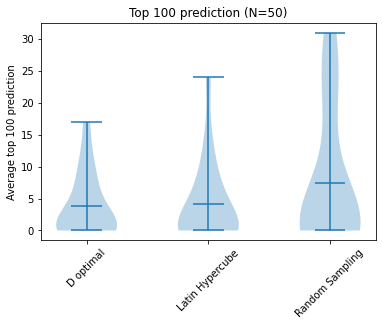

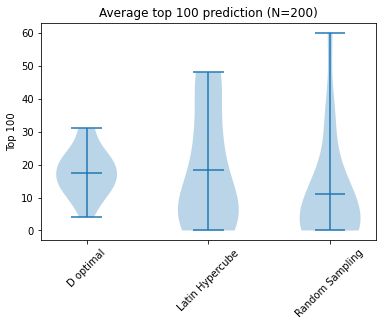

In [59]:
pos=[1,2,3]
fig,ax=plt.subplots()
plt.violinplot(R_Doptimal.iloc[:,:3],showmeans=True)
ax.set_xticks(pos)
plt.title("Top 100 prediction (N=50)")
cols_50=["D optimal", "Latin Hypercube","Random Sampling"]
ax.set_xticklabels(cols_50,rotation=45)
plt.ylabel("Average top 100 prediction")
plt.savefig("../../../Results/Benchmark paper/Top100_D_LHS_RS_50.svg",bbox_inches="tight")
# plt.ylim((0,1))
plt.show()

pos=[1,2,3]
fig,ax=plt.subplots()
plt.violinplot(R_Doptimal.iloc[:,3:],showmeans=True)
ax.set_xticks(pos)
plt.title("Average top 100 prediction (N=200)")
cols_50=["D optimal", "Latin Hypercube","Random Sampling"]
ax.set_xticklabels(cols_50,rotation=45)
plt.savefig("../../../Results/Benchmark paper/Top100_D_LHS_RS_200.svg",bbox_inches="tight")
# plt.ylim((0,1))
plt.ylabel("Top 100")
plt.show()